In [1]:
import numpy as np
import pandas as pd
import torch as th
import dgl
from dgl.data import CiteseerGraphDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from awa2_graph_dataset import *

Using backend: pytorch


In [2]:
def plot_features(features, labels, tsne_args, cmap='tab20'):
    # 分布式随机邻居嵌入
    proj = TSNE(random_state=0, **tsne_args).fit_transform(features)
    fig, ax = plt.subplots(figsize=(8,8))
    # cmap 颜色的调色板 c 颜色
    scatter = ax.scatter(proj[:,0], proj[:,1], c=labels, s=2, cmap=cmap)
    plt.legend(*scatter.legend_elements())
    ax.set(title='TSNE of features')
    _ = ax.grid()

In [3]:
dataset = AwA2GraphDataset()
g = dataset[0]
# get node feature
feat = g.ndata['feat']
# get data split
train_mask = g.ndata['train_mask']
# val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']
# get labels
label = g.ndata['label']

num_class = label.unique().shape[0]

In [4]:
train_nodes = np.arange(g.num_nodes())[train_mask]
# val_nodes = np.arange(g.num_nodes())[val_mask]
test_nodes = np.arange(g.num_nodes())[test_mask]

In [5]:
train_val_test_label = np.zeros(g.num_nodes())
train_val_test_label[train_mask] = 1
# train_val_test_label[val_mask] = 2
train_val_test_label[test_mask] = 2
train_val_test_label

array([1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1.,
       2., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 1.])

In [6]:
feat.shape

torch.Size([50, 85])

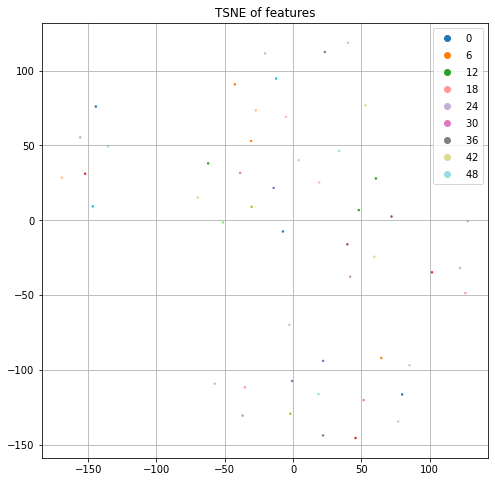

In [7]:
plot_features(
    feat.numpy(), label.numpy(), 
    {'perplexity': 15},
)

In [8]:
from dgl.nn import GraphConv
import torch.nn.functional as F
import torch.nn as nn

In [9]:
class AwA2Conv(nn.Module):
    def __init__(self, g, num_feature, num_output):
        super(AwA2Conv, self).__init__()
        self.g = g
        self.conv1 = GraphConv(num_feature, 512)
        self.conv2 = GraphConv(512, 1024)
        self.conv3 = GraphConv(1024, num_output)

    def forward(self, x):
        h = self.conv1(self.g, x)
        h = F.leaky_relu(h)
        h = self.conv2(self.g, h)
        h = F.leaky_relu(h)
        h = self.conv3(self.g, h)
        g.ndata["h"] = h
        return h
        # return dgl.mean_nodes(g, "h")

In [10]:
eye_feat = th.eye(feat.shape[0])

In [11]:
gcn_wo_features_1 = AwA2Conv(g, feat.shape[0], 2049)

proj_wo = TSNE(perplexity=15).fit_transform(gcn_wo_features_1(eye_feat).detach().cpu().numpy()) 

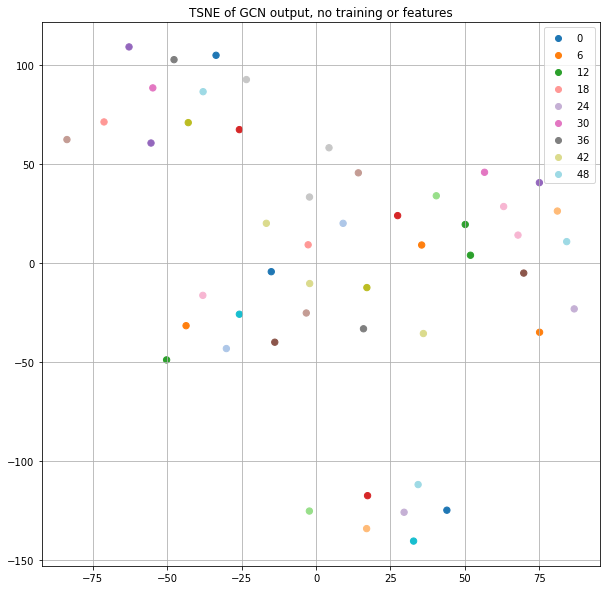

In [12]:

fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj_wo[:,0], proj_wo[:,1], 
    c=label.numpy(), # label
    s=40, cmap='tab20'
)

plt.legend(*scatter.legend_elements())
ax.set(title='TSNE of GCN output, no training or features')
_ = ax.grid()

In [13]:
idx_roi_wo = np.array([
    6
])

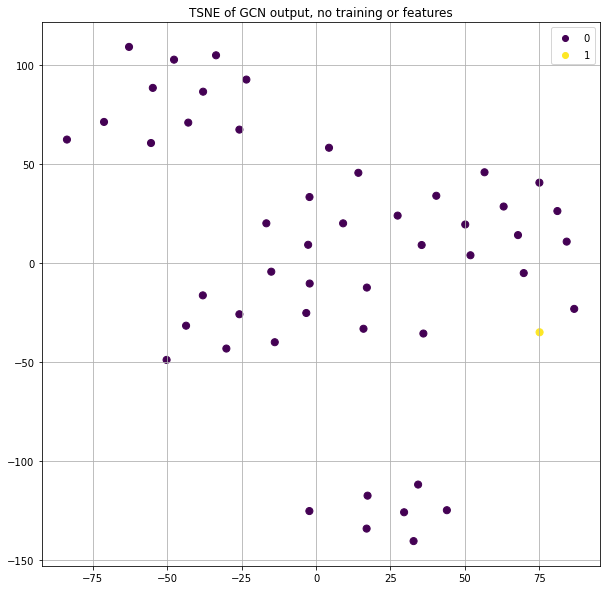

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(
    proj_wo[:,0], proj_wo[:,1], 
    c=np.array([n in idx_roi_wo for n in range(proj_wo.shape[0])]), # label
    s=50,
)

plt.legend(*scatter.legend_elements())
ax.set(title='TSNE of GCN output, no training or features')
_ = ax.grid()

In [16]:
gcn_wo_features_2 = AwA2Conv(g, feat.shape[0], 2049)
gcn_wo_features_2.load_state_dict(torch.load("/home/tyc/zsl-1/model/awa2-gcn-model.bin"))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.